In [1]:
import csv
import os
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
#accessing my code again
df_sflistings = pd.read_csv('df_sflistings.csv')
df_nyclistings = pd.read_csv('df_nyclistings.csv')

In [3]:
#for SF
X_sf = df_sflistings.drop(columns=['price'])  #independent variables
y_sf = df_sflistings['price']  #dependent variable

#adding a constant term to the independent variables matrix
X_sf = sm.add_constant(X_sf)

#for NYC
X_nyc = df_nyclistings.drop(columns=['price'])  #independent variables
y_nyc = df_nyclistings['price']  #dependent variable

#adding a constant term to the independent variables matrix
X_nyc = sm.add_constant(X_nyc)

In [4]:
#finding the optimal alpha for LASSO regression

def find_best_alpha(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    alphas_lasso = np.linspace(1e-6, 1, num=50)

    MSE_lasso = float('inf')
    best_alpha_lasso = 0

    cv_errs_lasso = []
    coefs_lasso = []

    for alpha in alphas_lasso:
        lassoReg = Lasso(alpha=alpha*np.sqrt(X_train_scaled.shape[0]), max_iter=10000)  # Increase max_iter
        lassoReg.fit(X_train_scaled, y_train)
        y_pred = lassoReg.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        cv_errs_lasso.append(mse)
        coefs_lasso.append(lassoReg.coef_)
        if mse < MSE_lasso:
            MSE_lasso = mse
            best_alpha_lasso = alpha

    best_alpha_index = np.argmin(cv_errs_lasso)
    print("Best alpha for Lasso regression:", alphas_lasso[best_alpha_index])
    print("Coefficients corresponding to the best alpha:")
    for i, (var_name, coef) in enumerate(zip(X_train.columns, coefs_lasso[best_alpha_index])):
        print(f"{var_name}: {coef}")

    return coefs_lasso[best_alpha_index]

#finding the optimal alpha for LASSO regression on SF listings
coefs_sf = find_best_alpha(X_sf, y_sf, X_sf, y_sf)

#finding the optimal alpha for LASSO regression on NYC listings
coefs_nyc = find_best_alpha(X_nyc, y_nyc, X_nyc, y_nyc)

Best alpha for Lasso regression: 1e-06
Coefficients corresponding to the best alpha:
const: 0.0
minimum_nights: -26.07423741947916
number_of_reviews: -18.737484551107613
calculated_host_listings_count: -23.844370657450995
availability_365: 19.87853702059722
number_of_reviews_ltm: -8.007495253460492
neighbourhood_Bernal Heights: 24.586515057857238
neighbourhood_Castro/Upper Market: 32.105696454532726
neighbourhood_Chinatown: 8.503024242105623
neighbourhood_Crocker Amazon: -1.0000864760203068
neighbourhood_Diamond Heights: 7.587417199723044
neighbourhood_Downtown/Civic Center: 32.77926623133088
neighbourhood_Excelsior: 0.3954308095369018
neighbourhood_Financial District: 12.889843402470781
neighbourhood_Glen Park: 4.673426325012962
neighbourhood_Golden Gate Park: 1.4768815971831486
neighbourhood_Haight Ashbury: 18.490156769908022
neighbourhood_Inner Richmond: 36.38641343063086
neighbourhood_Inner Sunset: 14.058241278330339
neighbourhood_Lakeshore: 1.208972612230113
neighbourhood_Marina: 

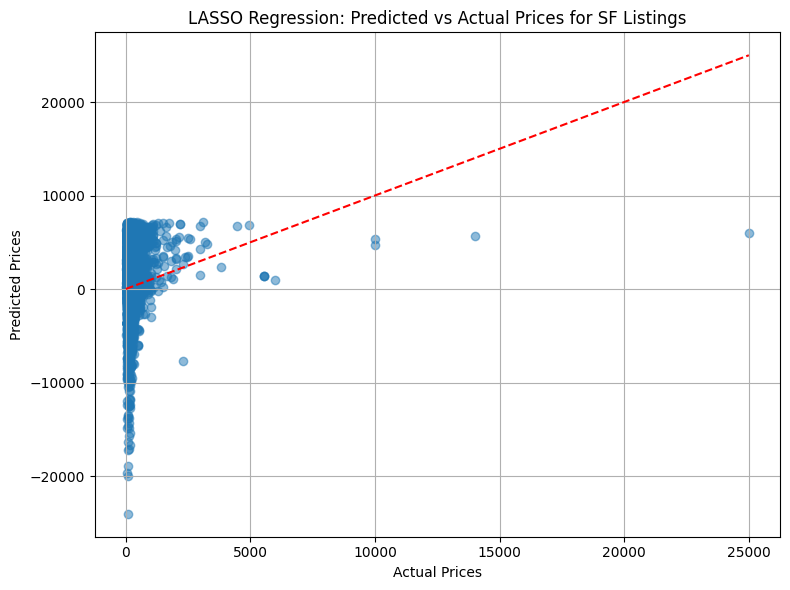

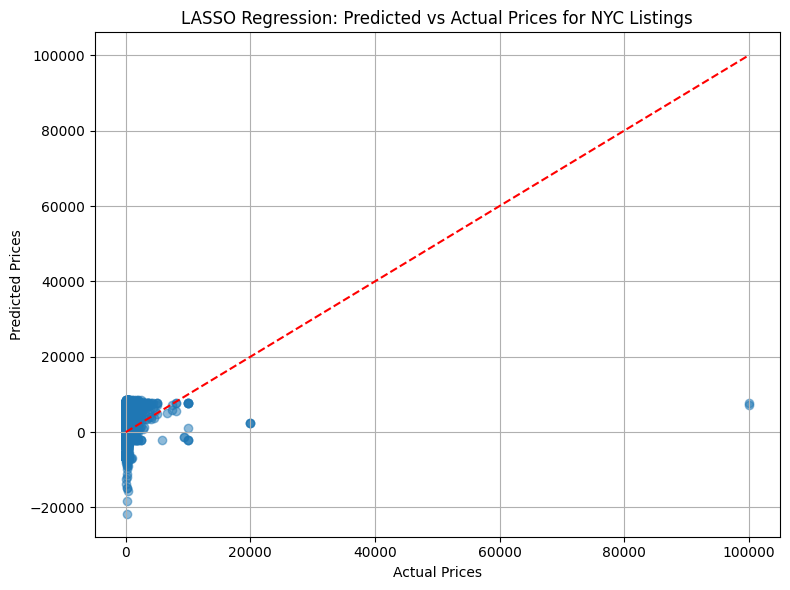

In [5]:
#plotting actual versus predicted values for both SF and NYC listings
def plot_predicted_vs_actual(y_actual, y_predicted, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5)
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
    plt.title(title)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#predicting prices based on LASSO coefficients for SF listings
y_predicted_sf = np.dot(X_sf, coefs_sf)

#predicting prices based on LASSO coefficients for NYC listings
y_predicted_nyc = np.dot(X_nyc, coefs_nyc)

#plotting for SF listings
plot_predicted_vs_actual(y_sf, y_predicted_sf, 'LASSO Regression: Predicted vs Actual Prices for SF Listings')

#plotting for NYC listings
plot_predicted_vs_actual(y_nyc, y_predicted_nyc, 'LASSO Regression: Predicted vs Actual Prices for NYC Listings')

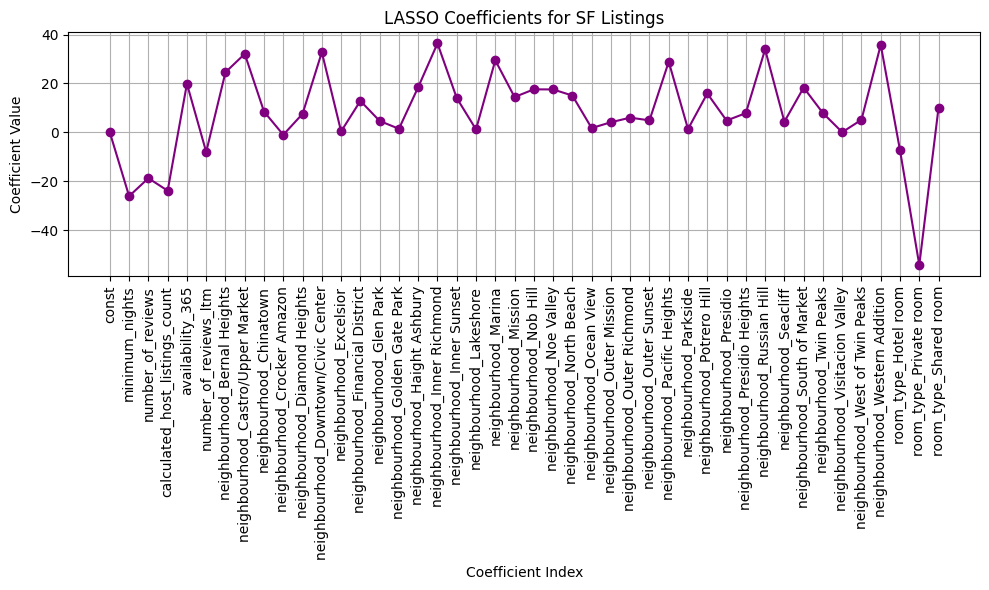

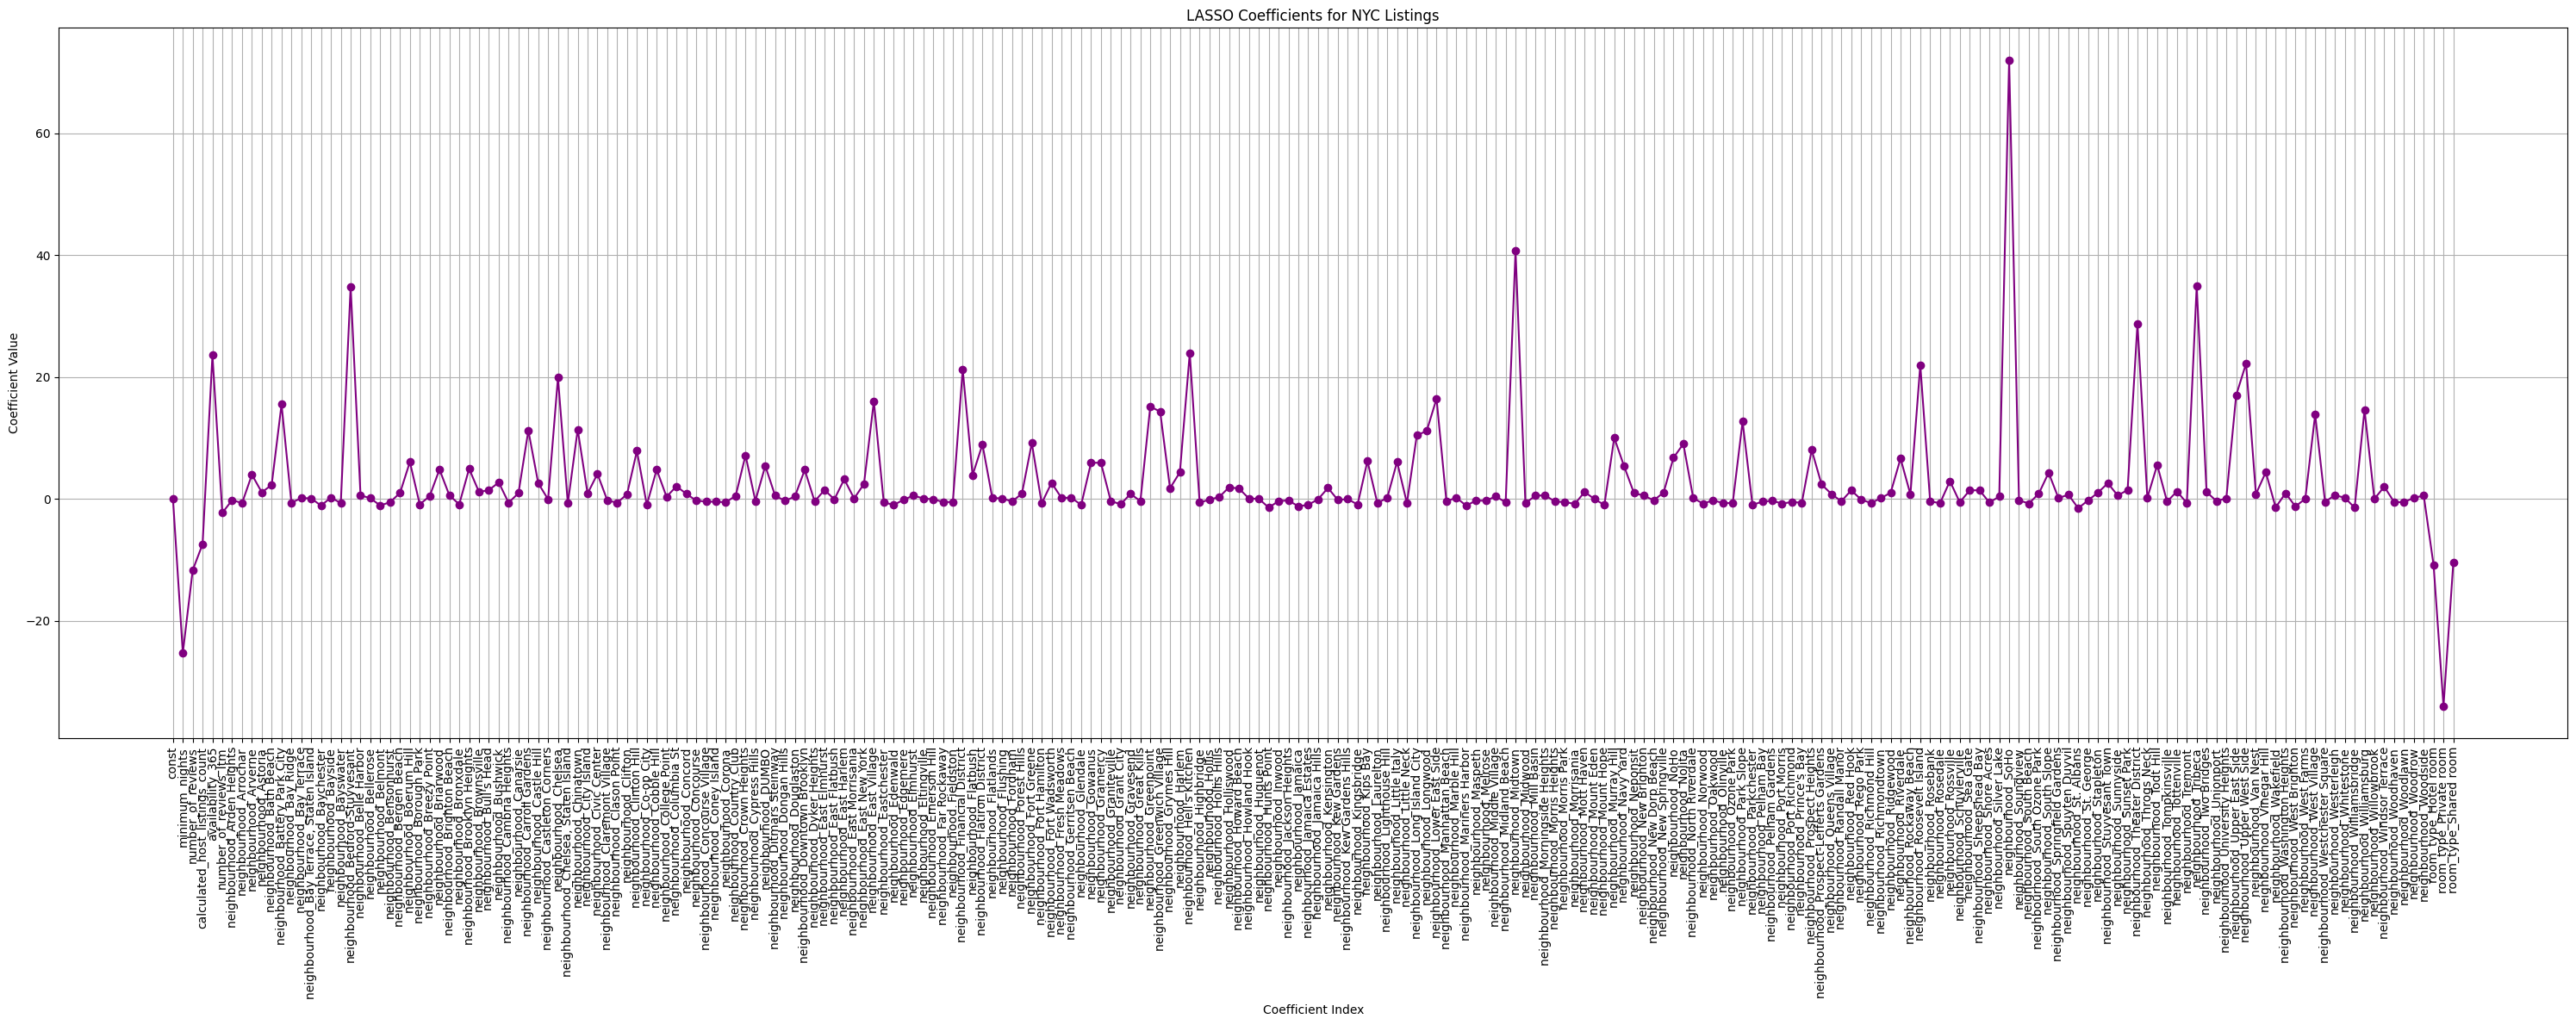

In [6]:
#plotting the LASSO coefficients for SF listings
plt.figure(figsize=(10, 6))
plt.plot(coefs_sf, marker='o', linestyle='-', color='purple')
plt.title('LASSO Coefficients for SF Listings')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.xticks(range(len(X_sf.columns)), X_sf.columns, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

#plotting the LASSO coefficients for NYC listings
plt.figure(figsize=(30, 12))
plt.plot(coefs_nyc, marker='o', linestyle='-', color='purple')
plt.title('LASSO Coefficients for NYC Listings')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.xticks(range(len(X_nyc.columns)), X_nyc.columns, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
#for viewing my total number of variables
print("Number of variables in the data-frame for San Francisco listings:", len(df_sflistings.columns))
print("Number of variables in the data-frame for New York City listings:", len(df_nyclistings.columns))

Number of variables in the data-frame for San Francisco listings: 44
Number of variables in the data-frame for New York City listings: 232


In [8]:
#obtaining summary statistics for my final write-up
print("Summary statistics for SF listings:")
print(df_sflistings.describe())

print("\nSummary statistics for NYC listings:")
print(df_nyclistings.describe())

Summary statistics for SF listings:
              price  minimum_nights  number_of_reviews  \
count   6774.000000     6774.000000        6774.000000   
mean     216.232211       19.271332          51.447741   
std      468.579471       43.799345         106.599721   
min       10.000000        1.000000           0.000000   
25%      100.000000        2.000000           0.000000   
50%      150.000000        3.000000           7.000000   
75%      224.000000       30.000000          49.000000   
max    25000.000000      500.000000        1166.000000   

       calculated_host_listings_count  availability_365  \
count                     6774.000000       6774.000000   
mean                        49.620165        204.502214   
std                        109.426442        122.940921   
min                          1.000000          0.000000   
25%                          1.000000         90.000000   
50%                          3.000000        215.000000   
75%                         